# Descriptive fit analysis

## NOTE: 5/3/18 - Accidentally overwrote with copy from non-alt experiment. Some of this will be wrong

### Here, I'll look at the descriptive fits to both experimental and simulated/model data to read off and analyze SF tuning properties

In [418]:
import numpy as np
import helper_fcns as hfunc
from scipy.stats.mstats import gmean
import autoreload
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('paul_plt_style.mplstyle')
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

savePltsSummary = 1;

save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/figures/'; # local
data_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/structures/'; # local
expName = 'dataList.npy';
fitName = 'fitList_180426_slowLR.npy';
descrName = 'descrFits.npy';
# descrModName = 'descrFitsModel.npy';
# respName = 'respAboveBase.npy';

muLoc = 2; # mu is in location '2' of parameter arrays

In [170]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.style'] = 'oblique'
rcParams['font.size'] = 12
rcParams['lines.markersize'] = 5
rcParams['lines.markeredgewidth'] = 2
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['xtick.minor.width'] = 1
rcParams['ytick.minor.width'] = 1
rcParams['xtick.major.size'] = 12
rcParams['ytick.major.size'] = 12
rcParams['xtick.minor.size'] = 7
rcParams['ytick.minor.size'] = 7
# rcParams['ticks.markeredgewidth'] = 3
# rcParams['axes.linewidth'] = 10
rcParams['pdf.fonttype'] = 3 # should be 42, but there are kerning issues
rcParams['ps.fonttype'] = 3 # should be 42, but there are kerning issues

In [10]:
nCells = 8;
# nFamilies = 4;
# nCons = 4;

useLowRespCut = 0; # should you filter the data based on analysis in "Considering responsivity..."

height = 3/4; # measure BW at half-height
sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details

In [11]:
dataList = np.load(data_loc + expName, encoding='latin1').item();
# respAbBase = np.load(data_loc + respName, encoding='latin1')

In [13]:
descrExp = np.load(data_loc + descrName, encoding='latin1').item()

In [20]:
modParams = np.load(data_loc + fitName, encoding='latin1').item();

## SfN 2018?

Quickly, on 5/3 (day of abstract deadline), let's see if the "tuned" normalization in the model accounts for the contrast-dependent shifts in SF tuning, and in exactly what way

In [21]:
save_name = 'cotuning.pdf';

In [22]:
filterSF = 0; # where in parameter array
normSF = -2; # where in parameter array

What are the relative preferences of the filter and the normalization pool?

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


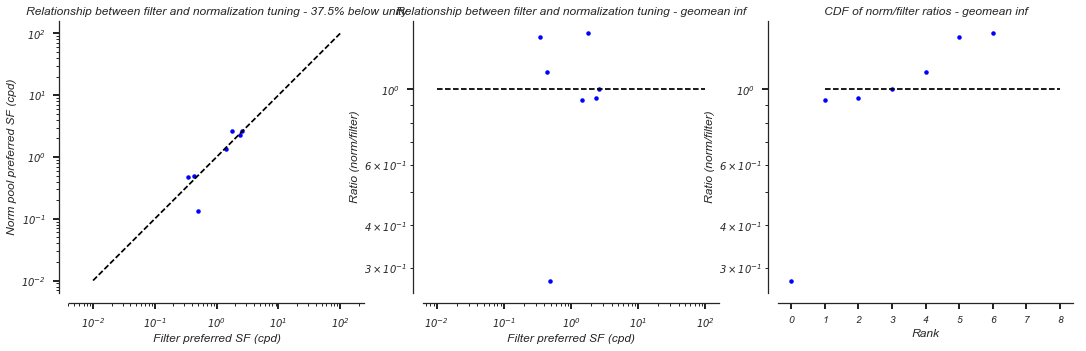

In [23]:
filt_vals = np.zeros((len(modParams), 1));
norm_vals = np.zeros((len(modParams), 1));
ratios = np.zeros((len(modParams), 1));
under_list = [];

for i in modParams:
    fv = modParams[i]['params'][filterSF];
    nv = np.exp(modParams[i]['params'][normSF])
    filt_vals[i] = fv;
    norm_vals[i] = nv;
    ratios[i] = nv/fv;
    if nv < fv:
        #print('cell %d' % (i+1))
        under_list.append(i);

sns.set_style('ticks')
sfn = plt.figure(figsize=(18, 5))

y = plt.subplot(1, 3, 1);
plt.loglog(filt_vals, norm_vals, 'b.');
#plt.loglog(filt_vals[under_list], norm_vals[under_list], 'r.');
plt.loglog([1e-2, 1e2], [1e-2, 1e2], 'k--');
plt.xlabel('Filter preferred SF (cpd)', fontSize = 'large');
plt.ylabel('Norm pool preferred SF (cpd)', fontSize = 'large');
below_unity = np.sum(ratios<=1) / len(ratios)
plt.title('Relationship between filter and normalization tuning - %.1f%% below unity' % (100*below_unity), fontSize = 'large');
plt.axis('equal')

plt.subplot(1, 3, 2);
plt.loglog(filt_vals, ratios, 'b.');
plt.loglog([1e-2, 1e2], [1, 1], 'k--');
plt.xlabel('Filter preferred SF (cpd)', fontSize = 'large');
plt.ylabel('Ratio (norm/filter)', fontSize = 'large');
gmRatio = gmean(ratios)
plt.title('Relationship between filter and normalization tuning - geomean %.2f' % (gmRatio), fontSize = 'large');

# as CDF
cdf_rats = np.argsort(ratios.transpose())[0];
plt.subplot(1, 3, 3);
plt.semilogy(range(len(cdf_rats)), ratios[cdf_rats], 'b.');
plt.semilogy([1, len(cdf_rats)], [1, 1], 'k--');
plt.xlabel('Rank', fontSize = 'large');
plt.ylabel('Ratio (norm/filter)', fontSize = 'large');
gmRatio = gmean(ratios)
plt.title('CDF of norm/filter ratios - geomean %.2f' % (gmRatio), fontSize = 'large');

sns.despine(offset = 10)

# save
pdfSv = pltSave.PdfPages(str(save_loc + save_name));
pdfSv.savefig(sfn)
pdfSv.close();


Next, list the cells in ascending order of ratio

In [24]:
asc_rats = np.argsort(ratios.transpose());
for i in range(len(asc_rats[0])):
    print('%d: %.3f' % (asc_rats[0][i]+1, ratios[asc_rats[0][i]]))

6: 0.276
1: 0.930
3: 0.945
4: 1.005
5: 1.127
2: 1.421
8: 1.459
7: inf


### Get bandwidth/prefSf measures organized

Which cells to consider?

In [387]:
validCells = [0, 1, 2, 3, 4, 5, 6] # by hand - some of the cells are junk!

Now, do the analysis

In [388]:
bwHeight = 3/4.; # i.e. bandwidth at half-height
sfLimits = [0.1, 10]; # limits of sf range we will consider for bandwidth calculation

nCellsVal = len(validCells);

# first, just load one cell to find out how many dispersions and valid contrasts per dispersion we have
cellStruct = np.load(data_loc + dataList['unitName'][i] + '_sfm.npy', encoding='latin1').item();
_, allConds, valCons, _, _ = hfunc.tabulate_responses(cellStruct);

allCons = allConds[1]; 

nCells = len(descrExp.keys());
nDisps = len(valCons);

descrPSF = dict(); # preferred SF as measured with descriptive function
descrBW = dict(); # SF BW as measured with descriptive function

for d in range(nDisps):
    nValCons = len(valCons[d]);
    descrBW[d] = np.zeros((nCellsVal, nValCons));
    descrPSF[d] = np.zeros((nCellsVal, nValCons))
    
    for cell_i in range(nCellsVal):
        cellInd = validCells[cell_i];
        for con_i in range(nValCons):
            currConInd = valCons[d][con_i]
            currFit = descrExp[cellInd]['params'][d][currConInd, :]

            descrBW[d][cell_i, con_i] = hfunc.compute_SF_BW(currFit, bwHeight, sfLimits)[1]; # octave bandwidth
            descrPSF[d][cell_i, con_i] = hfunc.get_prefSF(currFit); # in cpd


#### Plots

Median prefSF/BW

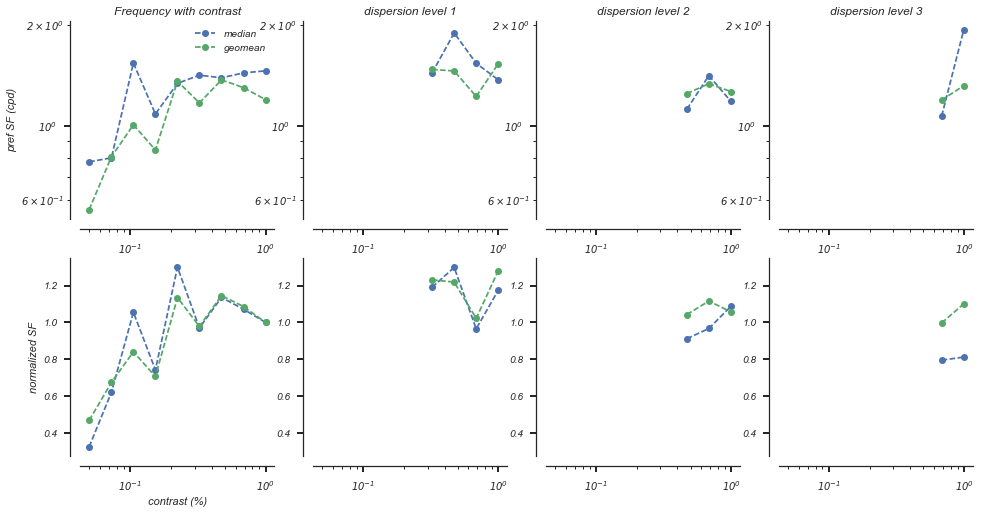

In [426]:
sfFig, sfAx = plt.subplots(2, nDisps, figsize=(4*nDisps, 8), sharex=True, sharey='row');

for cond in range(2): # one normalized, one unnormalized

    for d in range(nDisps):

        conVals = allCons[valCons[d]];
        descrPSF_curr = descrPSF[d];
        if cond == 1: # then normalize
            norm_factor = np.broadcast_to(np.expand_dims(descrPSF[0][:, -1], -1), (nCellsVal, len(valCons[d])))
            descrPSF_curr = np.divide(descrPSF_curr, norm_factor)
            
        medians = np.median(descrPSF_curr, axis=0)
        geomeans = gmean(descrPSF_curr, axis=0)

        med = sfAx[cond, d].semilogx(conVals, medians, '--o')
        geo = sfAx[cond, d].semilogx(conVals, geomeans, '--o')

        if d == 0 and cond == 0:
            sfAx[cond, d].set_ylabel('pref SF (cpd)');
            sfAx[cond, d].set_title('Frequency with contrast')
            sfAx[cond, d].legend([med[0], geo[0]], ['median', 'geomean'])
            sfAx[cond, d].set_yscale('log');
        elif cond == 0:
            sfAx[cond, d].set_title('dispersion level %d' % (d))
            sfAx[cond, d].set_yscale('log');
        elif d == 0 and cond == 1:
            sfAx[cond, d].set_ylabel('normalized SF');
            sfAx[cond, d].set_xlabel('contrast (%)');
        sns.despine(ax=sfAx[cond, d], offset=10)

    sns.set_style('ticks')


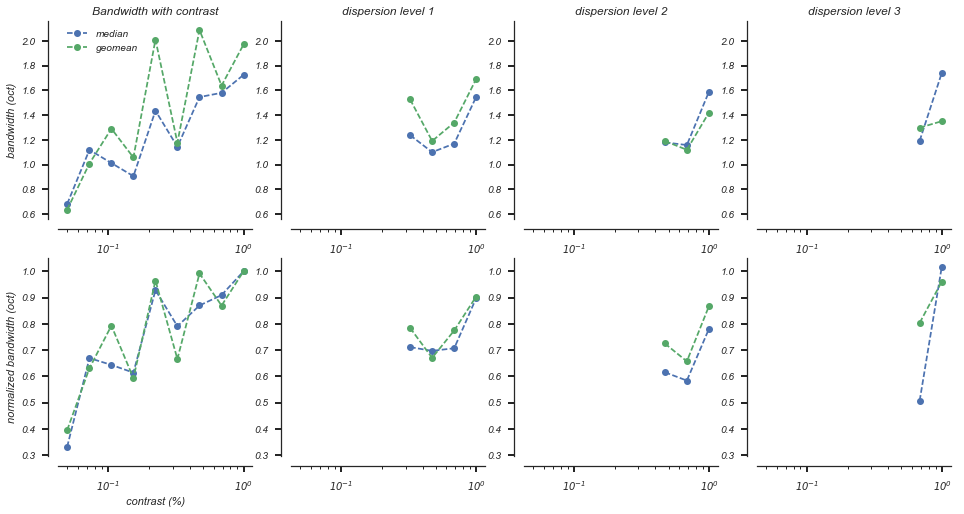

In [427]:
bwFig, bwAx = plt.subplots(2, nDisps, figsize=(4*nDisps, 8), sharex=True, sharey='row');

for cond in range(2): # one normalized, one unnormalized

    for d in range(nDisps):

        conVals = allCons[valCons[d]];
        descrBW_curr = descrBW[d];
        if cond == 1: # then normalize
            norm_factor = np.broadcast_to(np.expand_dims(descrBW[0][:, -1], -1), (nCellsVal, len(valCons[d])))
            descrBW_curr = np.divide(descrBW_curr, norm_factor)
            
        medians = np.nanmedian(descrBW_curr, axis=0)
        means = np.nanmean(descrBW_curr, axis=0)

        med = bwAx[cond, d].semilogx(conVals, medians, '--o')
        men = bwAx[cond, d].semilogx(conVals, means, '--o')

        if d == 0 and cond == 0:
            bwAx[cond, d].set_ylabel('bandwidth (oct)');
            bwAx[cond, d].set_title('Bandwidth with contrast')
            bwAx[cond, d].legend([med[0], men[0]], ['median', 'geomean'])
        elif cond == 0:
            bwAx[cond, d].set_title('dispersion level %d' % (d))
        elif d == 0 and cond == 1:
            bwAx[cond, d].set_ylabel('normalized bandwidth (oct)');
            bwAx[cond, d].set_xlabel('contrast (%)');
        sns.despine(ax=bwAx[cond, d], offset=10)

    sns.set_style('ticks')


Histogram of shifts - within-cell analysis

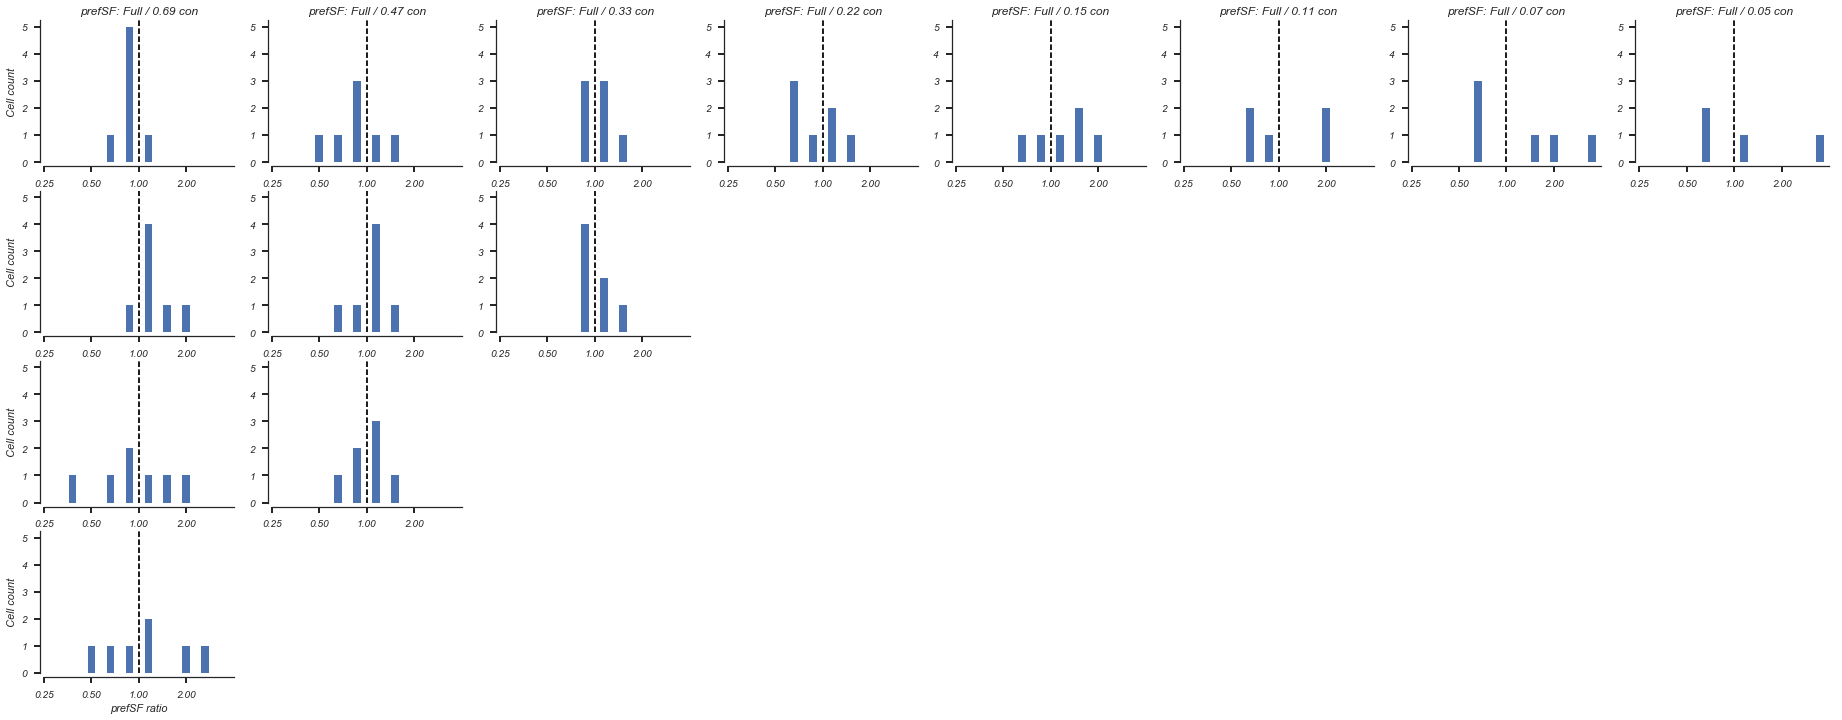

In [428]:
maxCons = np.max([len(x) for x in valCons]);
sfHistFig, sfHistAx = plt.subplots(nDisps, maxCons-1, figsize=((maxCons-1)*4, 3*nDisps), sharex=True, sharey=True);

xlims = [-2, 2]; # in log2
bins = np.linspace(xlims[0], xlims[-1], 11)

for d in range(nDisps):

    conVals = allCons[valCons[d]];
    descrPSF_curr = descrPSF[d];
    
    pos_curr = 0;
    for curr_con in reversed(range(len(valCons[d])-1)):
        
        currRats = [x[-1]/x[curr_con] for x in descrPSF[d]]
        sfHistAx[d, pos_curr].hist(np.log2(currRats), bins, rwidth=0.4);
        sfHistAx[d, pos_curr].set_xticks(np.arange(xlims[0], xlims[-1]));
        sfHistAx[d, pos_curr].set_xticklabels(['%.2f' % (np.power(2., x)) for x in np.arange(xlims[0], xlims[-1])])
        sfHistAx[d, pos_curr].axvline(0, ls='--', color='k')
        sfHistAx[d, pos_curr].set_xlim(xlims[0], xlims[-1])
        if d == 0:
            sfHistAx[d, pos_curr].set_title('prefSF: Full / %.2f con' % conVals[curr_con])
        if pos_curr == 0:
            sfHistAx[d, pos_curr].set_ylabel('Cell count')
            if d == nDisps-1:
                sfHistAx[d, pos_curr].set_xlabel('prefSF ratio')
   
        sns.despine(offset=4)
        pos_curr = pos_curr+1;
    
    while pos_curr < maxCons-1:
        sfHistAx[d, pos_curr].set_visible(False);
        pos_curr=pos_curr+1
        
sns.set_style('ticks');


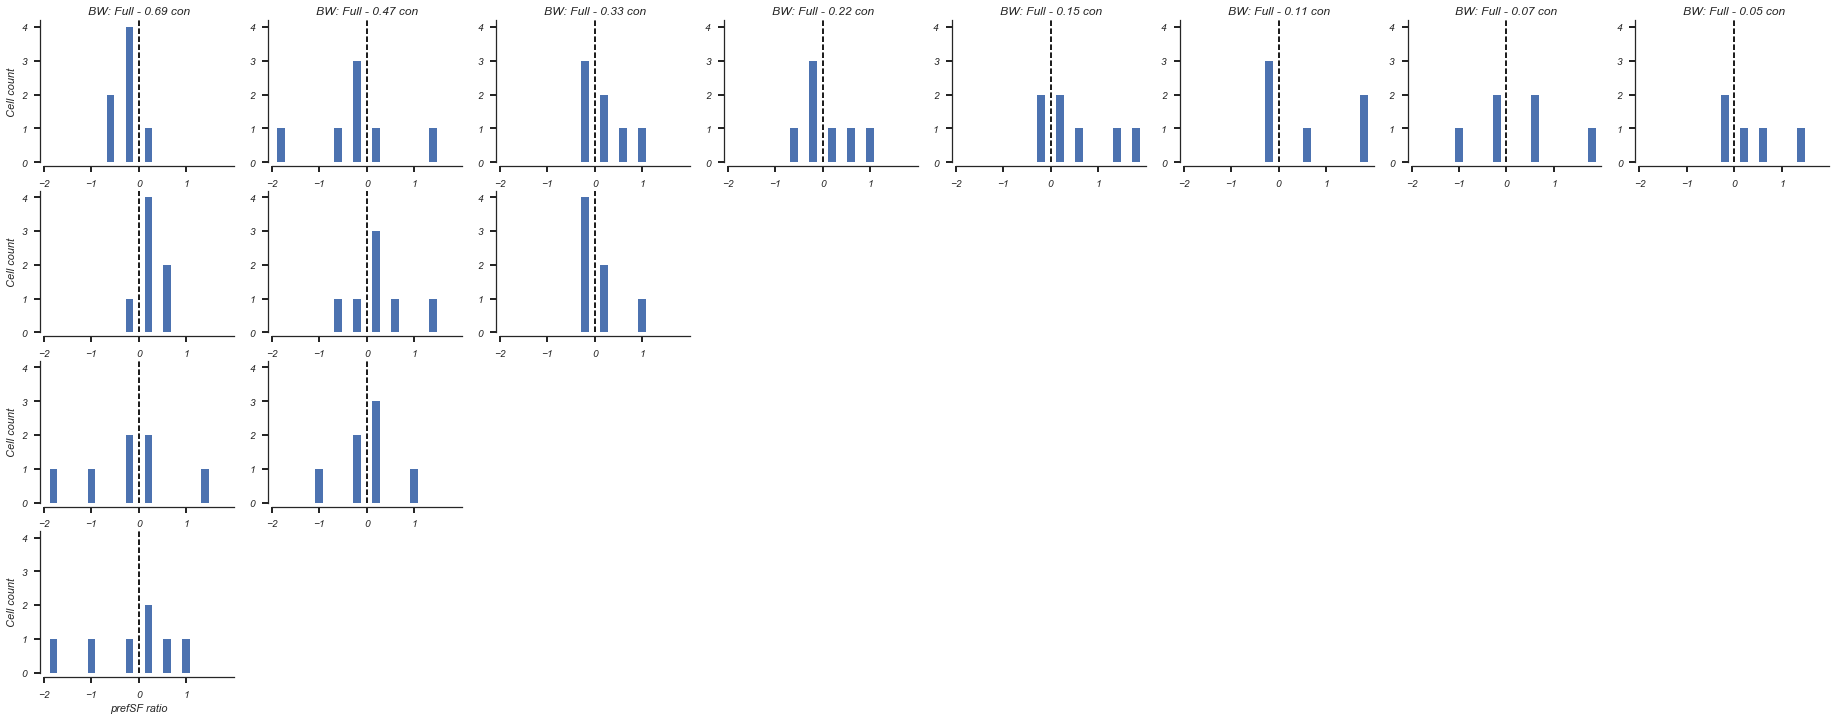

In [429]:
maxCons = np.max([len(x) for x in valCons]);
bwHistFig, bwHistAx = plt.subplots(nDisps, maxCons-1, figsize=((maxCons-1)*4, 3*nDisps), sharex=True, sharey=True);

xlims = [-2, 2];
bins = np.linspace(xlims[0], xlims[-1], 11)

for d in range(nDisps):

    conVals = allCons[valCons[d]];
    descrPSF_curr = descrBW[d];
    
    pos_curr = 0;
    for curr_con in reversed(range(len(valCons[d])-1)):
        
        currRats = [x[-1] - x[curr_con] for x in descrPSF[d]]
        bwHistAx[d, pos_curr].hist(currRats, bins, rwidth=0.4);
        bwHistAx[d, pos_curr].set_xticks(np.arange(xlims[0], xlims[1]));
        bwHistAx[d, pos_curr].axvline(0, ls='--', color='k')
        bwHistAx[d, pos_curr].set_xlim(xlims[0], xlims[-1])
        if d == 0:
            bwHistAx[d, pos_curr].set_title('BW: Full - %.2f con' % conVals[curr_con])
        if pos_curr == 0:
            bwHistAx[d, pos_curr].set_ylabel('Cell count')
            if d == (nDisps-1):
                bwHistAx[d, pos_curr].set_xlabel('prefSF ratio')
   
        sns.despine(offset=4)
        pos_curr = pos_curr+1;
        
    while pos_curr < maxCons-1:
        bwHistAx[d, pos_curr].set_visible(False);
        pos_curr=pos_curr+1
        
sns.set_style('ticks');


#### Now save

In [430]:
if savePltsSummary:
    allFigs = [sfFig, sfHistFig, bwFig, bwHistFig];
    saveName = "changesConDisp.pdf";
    pdf = pltSave.PdfPages(str(save_loc + saveName))
    for fig in range(len(allFigs)): ## will open an empty extra figure :(
        pdf.savefig(allFigs[fig], bbox_inches="tight")
    pdf.close()

### Considering responsivity at low contrast & high dispersion

Inspired by chats with Najib, I should ensure that the effect of dispersion on contrast dependent shifts holds if we look only at cells with meaningful responses at the low contrast, maximal dispersion case.

In [14]:
peakCrit = 10; # i.e. cells with maximum response at low con/high disp condition below this won't be counted
ratCrit = 0.12; # i.e. cells whose sum of responses '''''' as a fraction of the same at high con/low disp won't be counted

In [15]:
nCells = len(dataList['unitName']);
peaks = np.zeros((nCells, 2)); # do (, 2) so we can compare high con/low disp to low con/high disp
sums = np.zeros((nCells, 2));

for c in range(nCells):
    responses = respAbBase[c, :, :, :];
    
    peaks[c, 0] = np.amax(responses[0][0]); # peak response for single grating, high contrast
    sums[c, 0] = np.sum(responses[0][0]);
    
    peaks[c, 1] = np.amax(responses[4][1]); # ' ' for maximum dispersion, low contrast
    sums[c, 1] = np.sum(responses[4][1]);
    
rats = np.divide(sums[:, 1], sums[:, 0]);

In [16]:
if useLowRespCut:
    # what's the criteri(a/on)?
    keepCells = rats > ratCrit;
    #keepCells = peaks[:, 1] > peakCrit;
    
    bwMod = bwMod[keepCells, :];
    bwExp = bwExp[keepCells, :];
    
    pSfExp = pSfExp[keepCells, :];
    pSfMod = pSfMod[keepCells, :];
    
    bwDiffMod = bwDiffMod[keepCells, :];
    bwDiffExp = bwDiffExp[keepCells, :];

    pSfRatioMod = pSfRatioMod[keepCells, :];
    pSfRatioExp = pSfRatioExp[keepCells, :];

### Plot BW differences

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


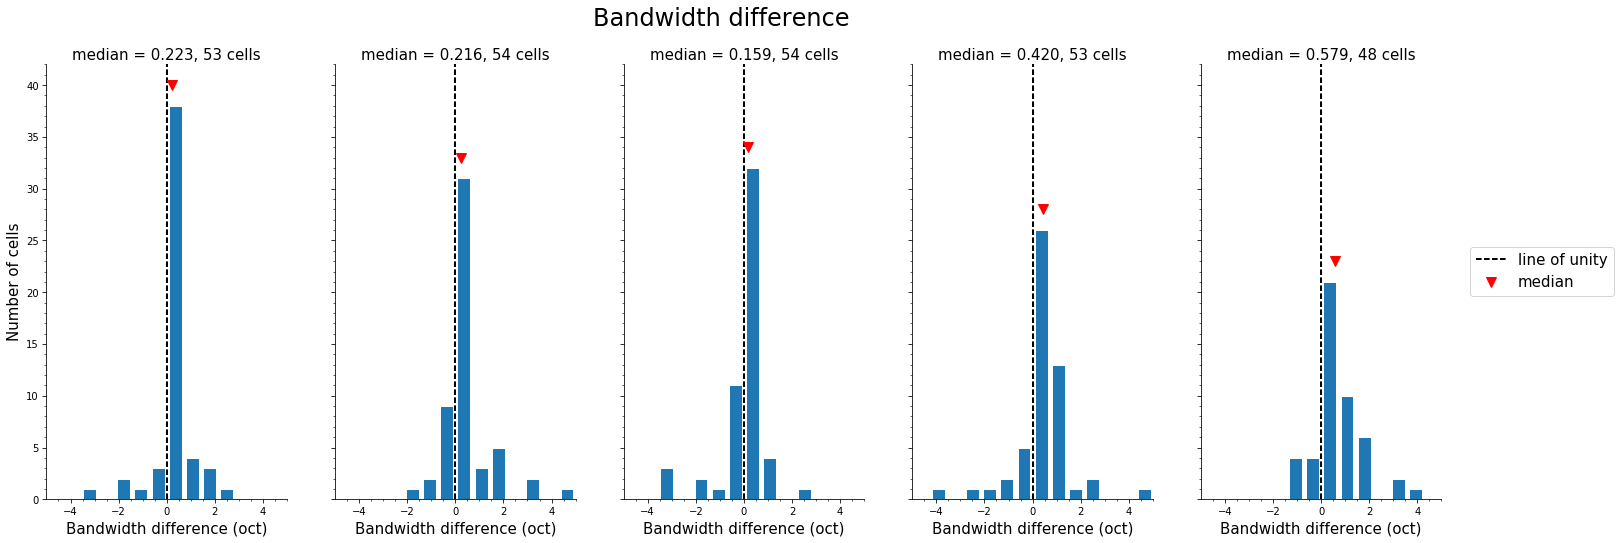

In [17]:
fig, allBW = plt.subplots(1, nFamilies, sharex='col', sharey='row', figsize=(25,8))

allBW[0].set_ylabel('Number of cells', fontsize=15);
binRange = (-5, 5)
nBins = 15;
binz = np.linspace(binRange[0], binRange[1], num=nBins);

for fam in range(nFamilies):
    validOnesExp = np.logical_and(bwDiffExp[:,fam]>-5, pSfRatioExp[:,fam]<5);
    toConsider = bwDiffExp[validOnesExp, fam];
    countz = allBW[fam].hist(toConsider, binz, alpha=1, rwidth=0.75);
    
    medianRatio = np.median(toConsider);
    allBW[fam].hold;
    
    unity = allBW[fam].axvline(0, ls='--', color='k', linewidth=2);
    medPt = allBW[fam].plot(medianRatio, np.amax(countz[0])+2, 'rv', markersize=10);
    
    allBW[fam].set_xlabel('Bandwidth difference (oct)', fontsize=15);
    allBW[fam].set_xlim(binRange);
    
    allBW[fam].text(0.5, 1.01,'median = {:.3f}, {:.0f} cells'.format(medianRatio, sum(countz[0])), horizontalalignment='center',\
                     transform=allBW[fam].transAxes, FontSize=15)
    
fig.legend((unity, medPt[0]), ('line of unity', 'median'), fontsize=15, loc='right');
plt.suptitle('Bandwidth difference', fontsize=24);

### Plot pSf ratios

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


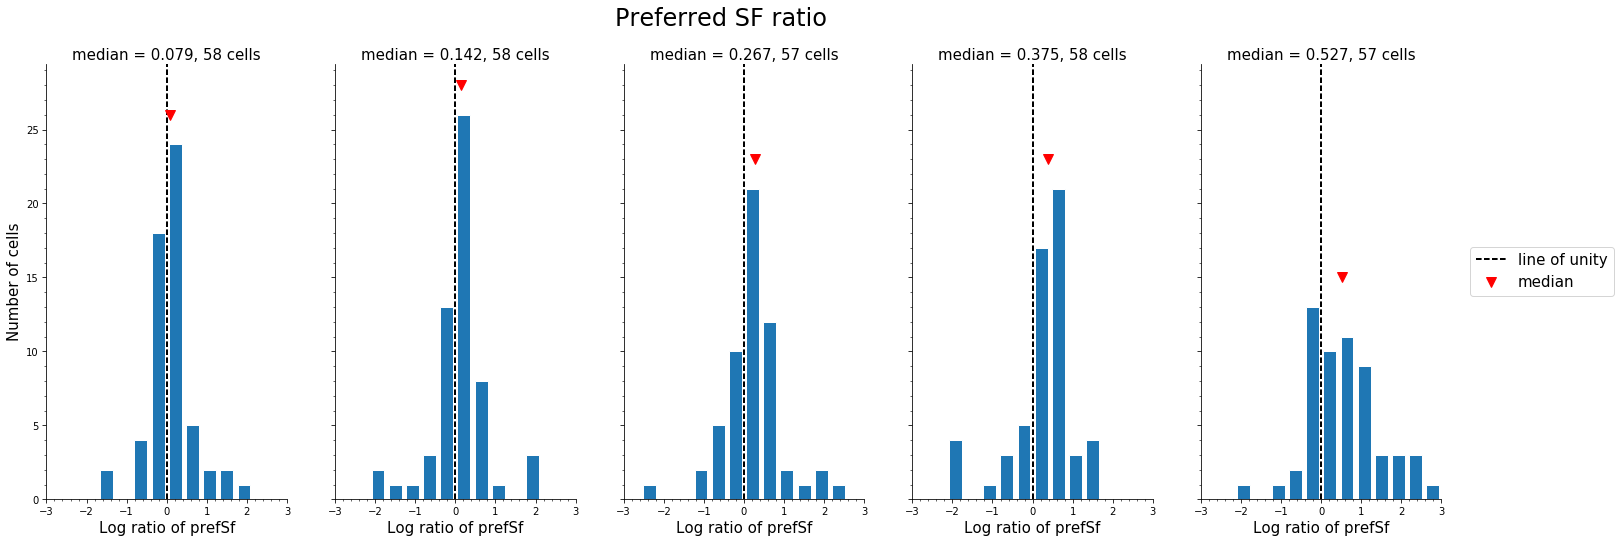

In [18]:
fig, allpSf = plt.subplots(1, nFamilies, sharex='col', sharey='row', figsize=(25,8))

allpSf[0].set_ylabel('Number of cells', fontsize=15)
binRange = (-3, 3) # in log2 space...
nBins = 15;
binz = np.linspace(binRange[0], binRange[1], num=nBins)

for fam in range(nFamilies):
    validOnesExp = np.logical_and(pSfRatioExp[:,fam]>0, pSfRatioExp[:,fam]<10);
    toConsider = np.log2(pSfRatioExp[validOnesExp, fam]);
    countz = allpSf[fam].hist(toConsider, binz, alpha=1, rwidth=0.75)

    medianRatio = np.median(toConsider);
    allpSf[fam].hold

    unity = allpSf[fam].axvline(0, ls='--', color='k', linewidth=2)
    medPt = allpSf[fam].plot(medianRatio, np.amax(countz[0])+2, 'rv', markersize=10)
    
    allpSf[fam].set_xlabel('Log ratio of prefSf', fontsize=15)
    allpSf[fam].set_xlim(binRange)
    
    allpSf[fam].text(0.5, 1.01,'median = {:.3f}, {:.0f} cells'.format(medianRatio, sum(countz[0])), horizontalalignment='center',\
                     transform=allpSf[fam].transAxes, FontSize=15)
    
fig.legend((unity, medPt[0]), ('line of unity', 'median'), fontsize=15, loc='right');
plt.suptitle('Preferred SF ratio', fontsize=24);

In [19]:
#plt.matplotlib.font_manager.findSystemFonts()

### Relationship between prefSf and sfBW (octaves)

In [25]:
np.median(pSfExp[:, 0, 0])

3.6050224736318839

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


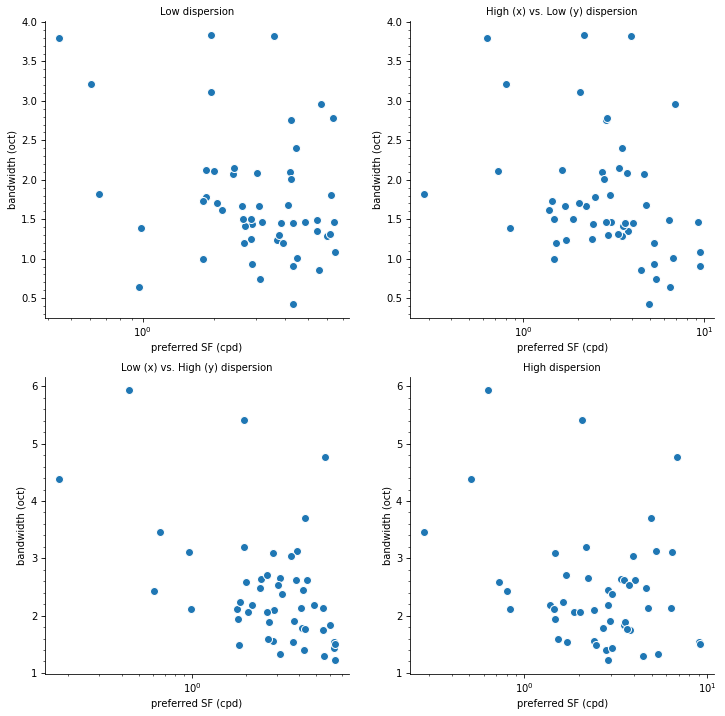

In [20]:
fig, prefVbw = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast

# Low versus Low
prefVbw[0, 0].semilogx(pSfLow, sfBwLow, 'o', mec='white');
prefVbw[0, 0].set_xlabel('preferred SF (cpd)');
prefVbw[0, 0].set_ylabel('bandwidth (oct)');
prefVbw[0, 0].set_title('Low dispersion');

# Low versus High
prefVbw[1, 0].semilogx(pSfLow, sfBwHigh, 'o', mec='white');
prefVbw[1, 0].set_xlabel('preferred SF (cpd)');
prefVbw[1, 0].set_ylabel('bandwidth (oct)');
prefVbw[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
prefVbw[0, 1].semilogx(pSfHigh, sfBwLow, 'o', mec='white');
prefVbw[0, 1].set_xlabel('preferred SF (cpd)');
prefVbw[0, 1].set_ylabel('bandwidth (oct)');
prefVbw[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
prefVbw[1, 1].semilogx(pSfHigh, sfBwHigh, 'o', mec='white');
prefVbw[1, 1].set_xlabel('preferred SF (cpd)');
prefVbw[1, 1].set_ylabel('bandwidth (oct)');
prefVbw[1, 1].set_title('High dispersion');


### Relationship between prefSf and sfBw (linear cpd)

Just a sanity check for correlation between prefSf and linear bandwidth

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


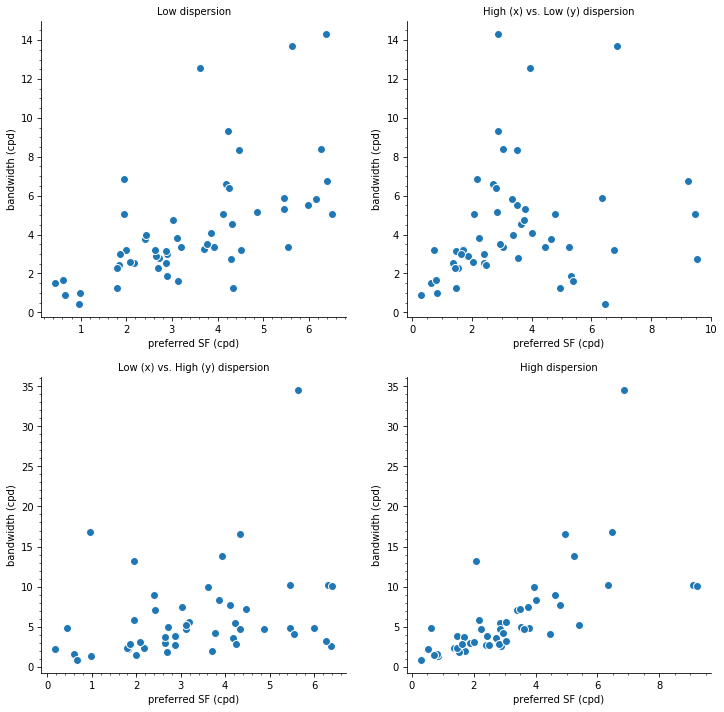

In [21]:
fig, prefVbw = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast

linLow = hfunc.bw_log_to_lin(sfBwLow, pSfLow);
linHigh = hfunc.bw_log_to_lin(sfBwHigh, pSfHigh);

# Low versus Low
prefVbw[0, 0].plot(pSfLow, linLow[0], 'o', mec='white');
prefVbw[0, 0].set_xlabel('preferred SF (cpd)');
prefVbw[0, 0].set_ylabel('bandwidth (cpd)');
prefVbw[0, 0].set_title('Low dispersion');

# Low versus High
prefVbw[1, 0].plot(pSfLow, linHigh[0], 'o', mec='white');
prefVbw[1, 0].set_xlabel('preferred SF (cpd)');
prefVbw[1, 0].set_ylabel('bandwidth (cpd)');
prefVbw[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
prefVbw[0, 1].plot(pSfHigh, linLow[0], 'o', mec='white');
prefVbw[0, 1].set_xlabel('preferred SF (cpd)');
prefVbw[0, 1].set_ylabel('bandwidth (cpd)');
prefVbw[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
prefVbw[1, 1].plot(pSfHigh, linHigh[0], 'o', mec='white');
prefVbw[1, 1].set_xlabel('preferred SF (cpd)');
prefVbw[1, 1].set_ylabel('bandwidth (cpd)');
prefVbw[1, 1].set_title('High dispersion');


### Correlations between preferred SF and ratio of pSf high/low

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


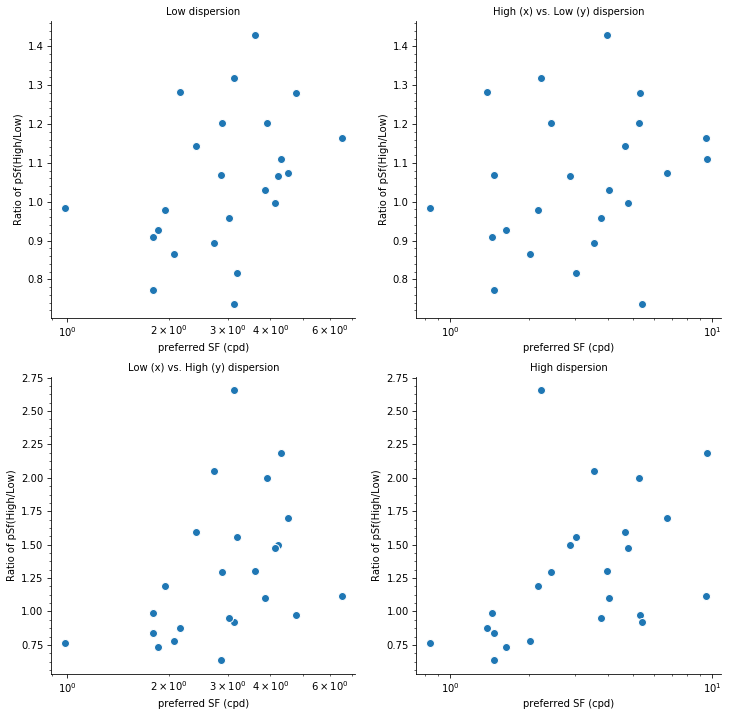

In [148]:
fig, pSfCorr = plt.subplots(2, 2, figsize = (12, 12));

pSfLow = pSfExp[:, 0, 0]; # pSf at low dispersion, high contrast
pSfShiftLow = pSfRatioExp[:, 0]; # ratio of pSf at high/low contrast for low dispersion

pSfHigh = pSfExp[:, 4, 0]; # pSf at high dispersion, high contrast
pSfShiftHigh = pSfRatioExp[:, 4]; # ratio of pSf at high/low contrast for high dispersion

# Low versus Low
pSfCorr[0, 0].semilogx(pSfLow, pSfShiftLow, 'o', mec='white');
pSfCorr[0, 0].set_xlabel('preferred SF (cpd)');
pSfCorr[0, 0].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[0, 0].set_title('Low dispersion');

# Low versus High
pSfCorr[1, 0].semilogx(pSfLow, pSfShiftHigh, 'o', mec='white');
pSfCorr[1, 0].set_xlabel('preferred SF (cpd)');
pSfCorr[1, 0].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
pSfCorr[0, 1].semilogx(pSfHigh, pSfShiftLow, 'o', mec='white');
pSfCorr[0, 1].set_xlabel('preferred SF (cpd)');
pSfCorr[0, 1].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
pSfCorr[1, 1].semilogx(pSfHigh, pSfShiftHigh, 'o', mec='white');
pSfCorr[1, 1].set_xlabel('preferred SF (cpd)');
pSfCorr[1, 1].set_ylabel('Ratio of pSf(High/Low)');
pSfCorr[1, 1].set_title('High dispersion');


### Correlations between measured BW and difference of bandwidth high-low (oct)

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


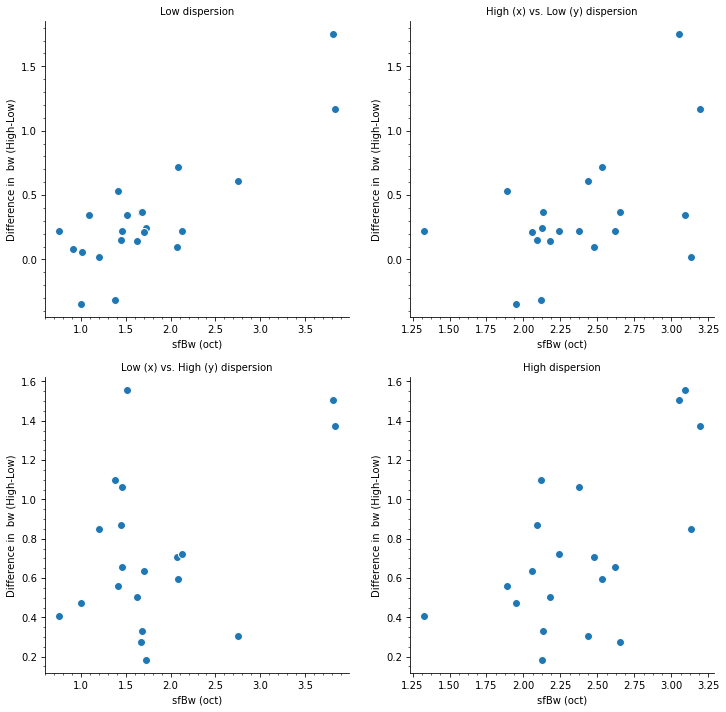

In [149]:
fig, sfBwCorr = plt.subplots(2, 2, figsize = (12, 12));

sfBwLow = bwExp[:, 0, 0]; # pSf at low dispersion, high contrast
sfBwShiftLow = bwDiffExp[:, 0]; # ratio of pSf at high/low contrast for low dispersion

sfBwHigh = bwExp[:, 4, 0]; # pSf at high dispersion, high contrast
sfBwShiftHigh = bwDiffExp[:, 4]; # ratio of pSf at high/low contrast for high dispersion

# Low versus Low
sfBwCorr[0, 0].plot(sfBwLow, sfBwShiftLow, 'o', mec='white');
sfBwCorr[0, 0].set_xlabel('sfBw (oct)');
sfBwCorr[0, 0].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[0, 0].set_title('Low dispersion');

# Low versus High
sfBwCorr[1, 0].plot(sfBwLow, sfBwShiftHigh, 'o', mec='white');
sfBwCorr[1, 0].set_xlabel('sfBw (oct)');
sfBwCorr[1, 0].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[1, 0].set_title('Low (x) vs. High (y) dispersion');

# High versus Low
sfBwCorr[0, 1].plot(sfBwHigh, sfBwShiftLow, 'o', mec='white');
sfBwCorr[0, 1].set_xlabel('sfBw (oct)');
sfBwCorr[0, 1].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[0, 1].set_title('High (x) vs. Low (y) dispersion');

# High versus high
sfBwCorr[1, 1].plot(sfBwHigh, sfBwShiftHigh, 'o', mec='white');
sfBwCorr[1, 1].set_xlabel('sfBw (oct)');
sfBwCorr[1, 1].set_ylabel('Difference in  bw (High-Low)');
sfBwCorr[1, 1].set_title('High dispersion');
